In [1]:
import yfinance as yf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [3]:
# Date Setup
start_date = datetime.today()
start = start_date.strftime('%Y-%m-%d')
end_date = start_date - timedelta(days=10*365)
end = end_date.strftime('%Y-%m-%d')

stock = 'TSLA'

In [4]:
# Correct way to call yfinance download
data = yf.download(stock, start=end, end=start)

# Reset and clean index
data.reset_index(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# Reset and clean index
data.reset_index(inplace=True)

In [6]:
data

Price,index,Date,Close,High,Low,Open,Volume
Ticker,,,TSLA,TSLA,TSLA,TSLA,TSLA
0,0,2015-04-15,13.855333,13.972667,13.773333,13.830667,29286000
1,1,2015-04-16,13.780000,13.944667,13.752667,13.846667,24886500
2,2,2015-04-17,13.786000,13.792000,13.566667,13.666000,37048500
3,3,2015-04-20,13.684667,13.856667,13.590000,13.785333,38389500
4,4,2015-04-21,13.960667,14.050000,13.620667,13.720000,51487500
...,...,...,...,...,...,...,...
2510,2510,2025-04-07,233.289993,252.000000,214.250000,223.779999,183453800
2511,2511,2025-04-08,221.860001,250.440002,217.800003,245.000000,171603500
2512,2512,2025-04-09,272.200012,274.690002,223.880005,224.690002,219433400


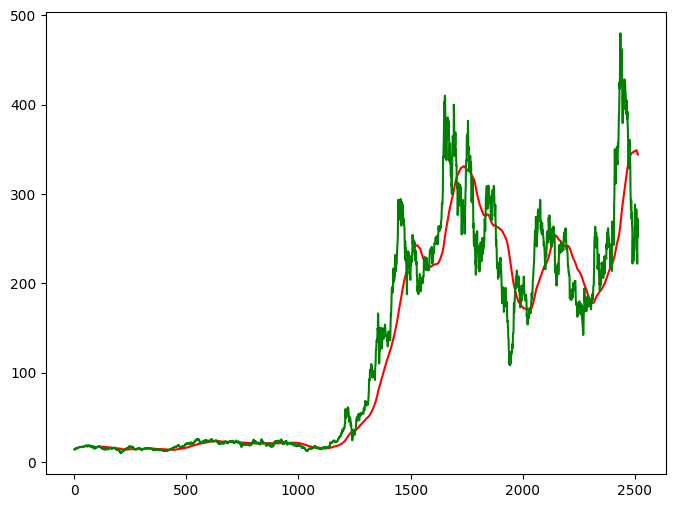

In [7]:
# 100-day moving average
ma_100_days = data['Close'].rolling(100).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(data['Close'], 'g')
plt.show()

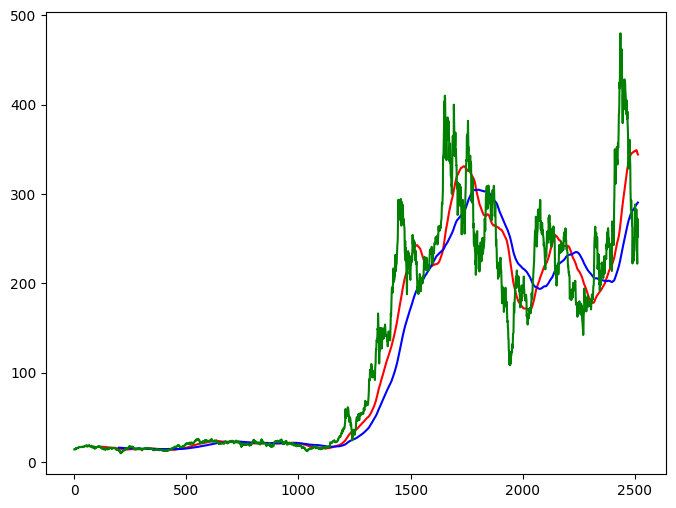

In [8]:
# 200-day moving average
ma_200_days = data['Close'].rolling(200).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r')
plt.plot(ma_200_days, 'b')
plt.plot(data['Close'], 'g')
plt.show()

In [9]:
# Drop NaN values
data.dropna(inplace=True)

In [10]:
# Split dataset
data_train = pd.DataFrame(data['Close'][0: int(len(data)*0.80)])
data_test = pd.DataFrame(data['Close'][int(len(data)*0.80): len(data)])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

In [11]:
# Prepare training data
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i, 0])

x, y = np.array(x), np.array(y)

In [12]:
# LSTM Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=50, batch_size=32, verbose=1)

model.summary()

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Test data setup
pas_100_days = data_train.tail(100)
data_test = pd.concat([pas_100_days, data_test], ignore_index=True)
data_test_scale = scaler.transform(data_test)

x_test = []
y_test = []

for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [ ]:
# Prediction
y_predict = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step


In [ ]:
# Inverse scale
scale = 1 / scaler.scale_[0]
y_predict = y_predict * scale
y_test = y_test * scale

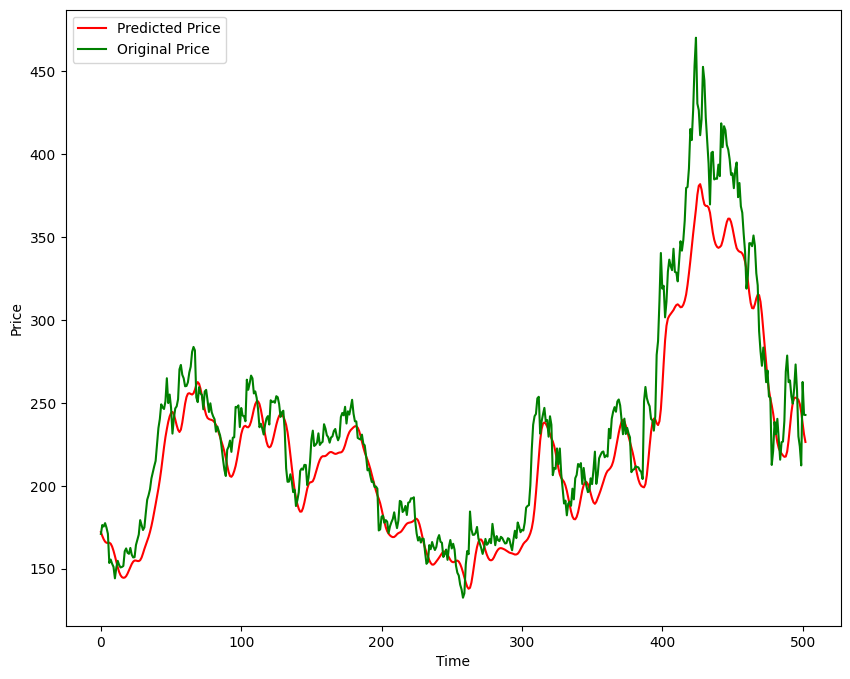

In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
plt.plot(y_predict, 'r', label='Predicted Price')
plt.plot(y_test, 'g', label='Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Save model
model.save('Stock_Predictions_Model.keras')